### Imports

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
from dataclasses import asdict

import einops
import matplotlib.pyplot as plt
import torch

from torch import Tensor

In [12]:
from flow_flowers.config import Config
from flow_flowers.data import FlowersDataset
from flow_flowers.model import AutoEncoder
from flow_flowers.utils import find_and_chdir

### Environment

In [13]:
torch.manual_seed(42)
find_and_chdir("config.yaml")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
config = Config.init("config.yaml")

### Perfom EDA on FlowersDataset

In [15]:
dataset = FlowersDataset(**asdict(config.data))

Dataset has 102 classes

In [81]:
dataset_labels = dataset.labels_
unique_labels = dataset_labels.unique()
print("Class count: ", unique_labels.nelement())

Class count:  102


Dataset has quite high class imbalance

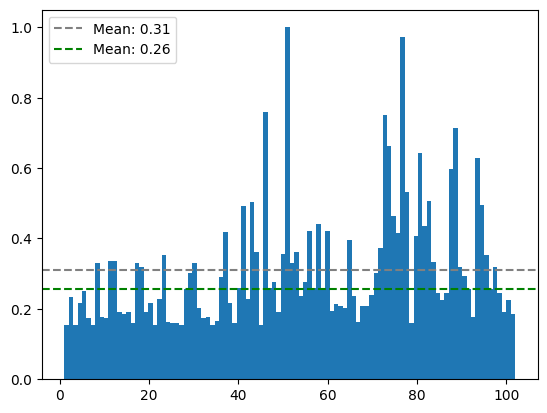

In [108]:
histogram = dataset_labels.float().histogram(bins=102)
norm_hist = histogram.hist / histogram.hist.max()

bin_edges = histogram.bin_edges
bin_width = bin_edges.diff()
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

hist_mean = norm_hist.mean().item()
hist_median = norm_hist.median().item()

plt.bar(bin_centers, norm_hist, bin_width)
plt.axhline(norm_hist.mean().item(), linestyle="--", color="gray", label="Mean: {:.2}".format(hist_mean))
plt.axhline(norm_hist.median().item(), linestyle="--", color="green", label="Mean: {:.2}".format(hist_median))
plt.legend()

In [139]:
shapes = []
for x, y in (dataset[i] for i in range(len(dataset))):
    assert x.ndim == 3, "images have different dims"
    shapes.append(torch.tensor(x.size()))

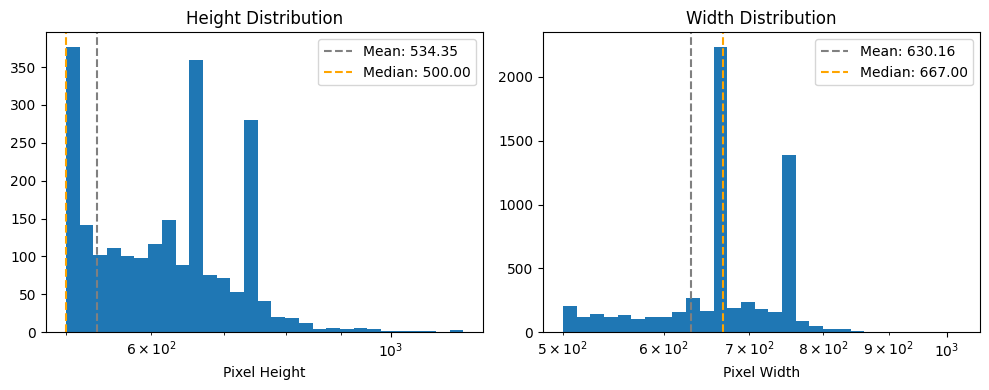

In [140]:
shapes: Tensor = einops.rearrange(shapes, "b s -> b s")

# Retrieve values
values_width = shapes[:, 2].float()
values_height = shapes[:, 1].float()
mean_width = values_width.mean().item()
mean_height = values_height.mean().item()
median_width = values_width.median().item()
median_height = values_height.median().item()

fig, (ax_h, ax_w) = plt.subplots(1, 2, figsize=(10, 4))

# Height histogram (same logic as width)
log_start_h = torch.log10(values_height.min()).item()
log_end_h = torch.log10(values_height.max()).item()
log_bins_h = torch.logspace(log_start_h, log_end_h, steps=30)
ax_h.hist(values_height, bins=log_bins_h)
ax_h.set_xscale("log")
ax_h.axvline(mean_height, color="gray", linestyle="--", label=f"Mean: {mean_height:.2f}")
ax_h.axvline(median_height, color="orange", linestyle="--", label=f"Median: {median_height:.2f}")
ax_h.set_title("Height Distribution")
ax_h.set_xlabel("Pixel Height")
ax_h.legend()

# Width histogram
log_start_w = torch.log10(values_width.min()).item()
log_end_w = torch.log10(values_width.max()).item()
log_bins_w = torch.logspace(log_start_w, log_end_w, steps=30)
ax_w.hist(values_width, bins=log_bins_w)
ax_w.set_xscale("log")
ax_w.axvline(mean_width, color="gray", linestyle="--", label=f"Mean: {mean_width:.2f}")
ax_w.axvline(median_width, color="orange", linestyle="--", label=f"Median: {median_width:.2f}")
ax_w.set_title("Width Distribution")
ax_w.set_xlabel("Pixel Width")
ax_w.legend()

plt.tight_layout()
plt.show()

### Assess DC-AE Reconstruction Quality

In [ ]:
vae = AutoEncoder(**asdict(config.model.autoencoder))

In [ ]:
n_samples = 10
x_index = torch.randperm(len(dataset))[:n_samples]
x_samples = einops.rearrange([dataset[i][0] for i in x_index], "b c h w -> b c h w")

RuntimeError: stack expects each tensor to be equal size, but got [3, 500, 666] at entry 0 and [3, 666, 500] at entry 1